# Практика 4: Атака DeepFool на модели ИИ

Выполнил: Асатрян Давид Робертович ББМО-01-23

# Цель:
Изучить атаку DeepFool, которая предназначена для минимальных изменений в изображениях с целью изменения их классификации. Научиться использовать эту атаку и исследовать влияние противоречивых примеров на обученные модели.

# Задачи:
Загрузить ранее обученную модель на датасете MNIST.
Изучить теоретические основы атаки DeepFool.
Реализовать атаку DeepFool с помощью фреймворка Foolbox.
Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

Шаг 1: Загруска библиотек

In [13]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Шаг 2: Загрузим обученную модель и данные MNIST

In [14]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9710 - loss: 0.1051
Test accuracy on clean images: 0.9746999740600586


Шаг 3: Реализация атаки DeepFool с использованием Foolbox

In [15]:
!pip install foolbox

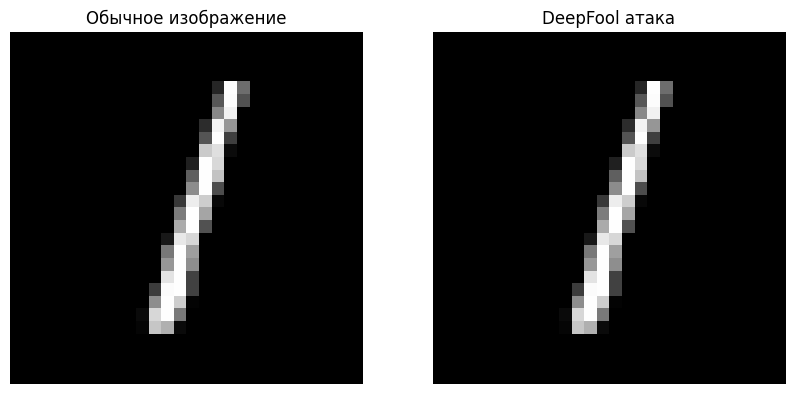

In [16]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Создание атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack(steps=50)

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[2], dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Обычное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("DeepFool атака")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

Шаг 4: Оценка модели на противоречивых примерах.

In [17]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

# Обработка изображений
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 3.2593e-04 - loss: 63.8105
Accuracy on adversarial examples (DeepFool): 0.00039999998989515007


# Вывод
Точность модели на противоречивых примерах, созданных с использованием атаки DeepFool, показывают крайне низкую точность, составившую всего 0,0004. Это подчеркивает уязвимость модели к атакам, даже когда визуальные изменения в изображении являются минимальными.